<a href="https://colab.research.google.com/github/OreamnosAR/Deep-Learning/blob/main/Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We supply two datasets, with points drawn from a 2D feature space, and a label assigned to each data point. The data has already been assigned to train and test sets. Each file is a table, where first column is the label, and the 2nd and 3rd columns are the features. This exercise does not require a gpu.

a: describe & visualize the data

In [1]:
#load packages
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn   # neural network
import sklearn.model_selection
import torch.nn.functional as F

In [84]:
#load data
relative_path = "/content/sample_data/trainData.txt"
traindf = pd.read_csv(relative_path,header=None,sep= " ",dtype=np.float64)

relative_path = "/content/sample_data/testData.txt"
testdf = pd.read_csv(relative_path,header=None,sep= " ",dtype=np.float64)

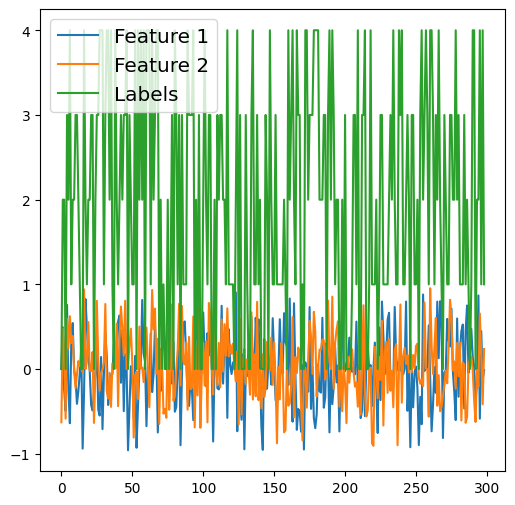

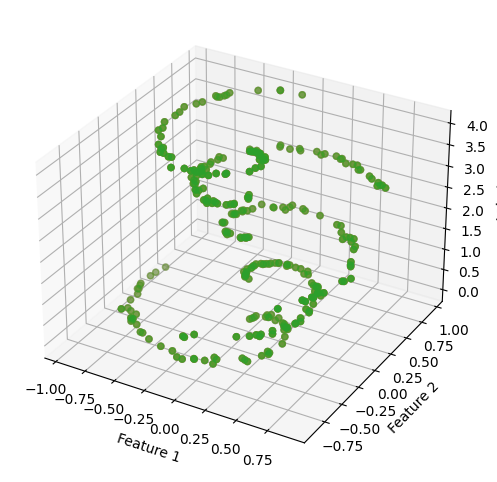

In [79]:
labels = testdf.iloc[:, 0]
x = testdf.iloc[:, 1]
y = testdf.iloc[:, 2]

#Plot in 2D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

line, = ax.plot(x, label='Feature 1')
line, = ax.plot(y, label='Feature 2')
line, = ax.plot(labels, label='Labels')

ax.legend(loc = 'upper left', fontsize ='x-large')

plt.show()

#Plot in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

for datapoint in testdf:
  ax.scatter(x, y, labels)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Label')

plt.show()

The 2D plot did not show any clear patterens. But the 3d plot do prehaps show some kind of circular pattern.
To explore the futher I will add plots showing each and the labels.

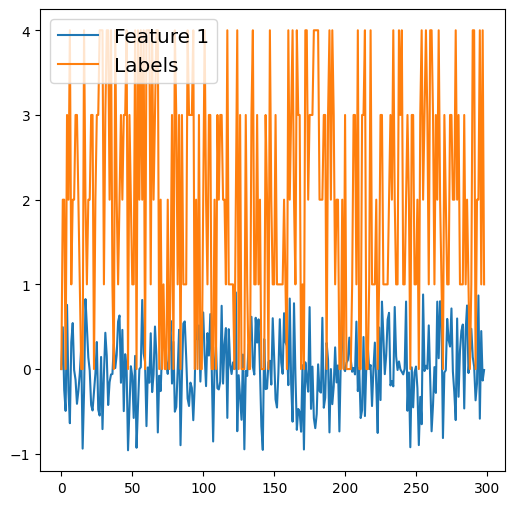

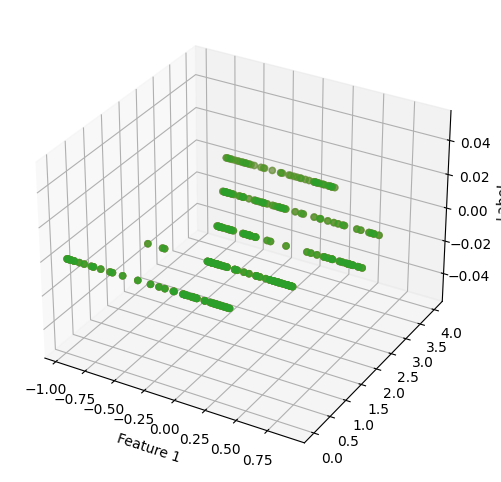

In [80]:
#Plot in 2D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
line, = ax.plot(x, label='Feature 1')
line, = ax.plot(labels, label='Labels')
ax.legend(loc = 'upper left', fontsize ='x-large')
plt.show()

#Plot in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
for datapoint in testdf:
  ax.scatter(x, labels)
ax.set_xlabel('Feature 1')
ax.set_zlabel('Label')
plt.show()

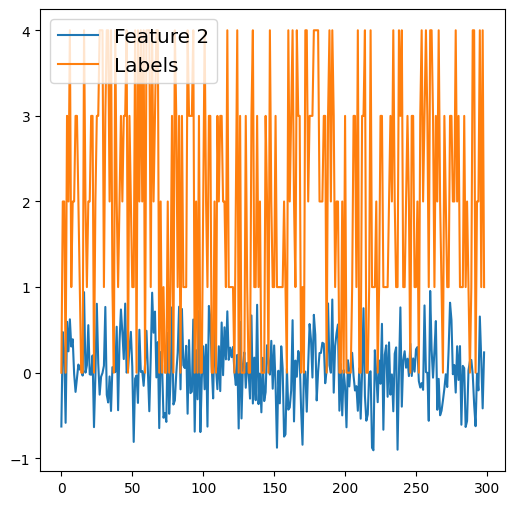

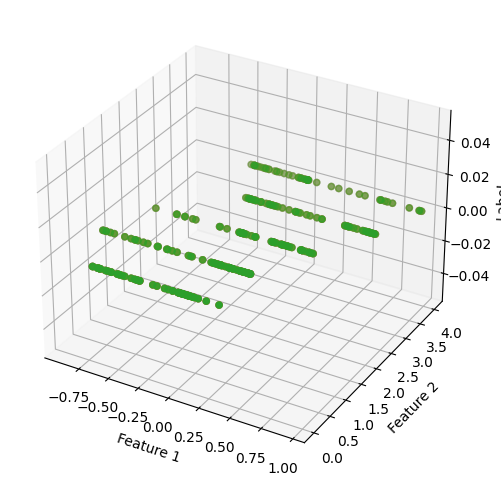

In [81]:
#Plot in 2D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
line, = ax.plot(y, label='Feature 2')
line, = ax.plot(labels, label='Labels')
ax.legend(loc = 'upper left', fontsize ='x-large')
plt.show()

#Plot in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
for datapoint in testdf:
  ax.scatter(y, labels)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Label')
plt.show()

These plots didnt replicate the circular pattern, so now I will create a plot of only the two features.

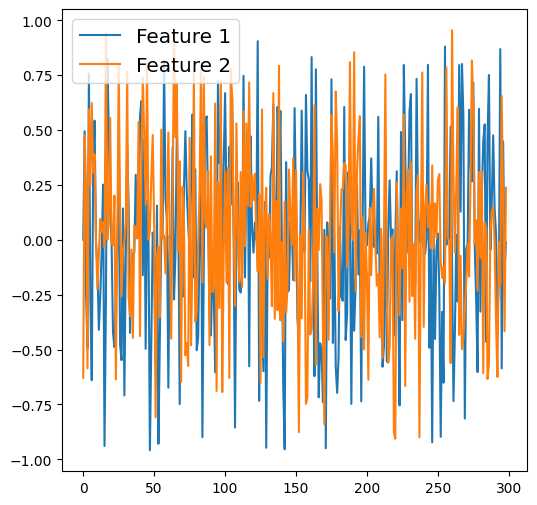

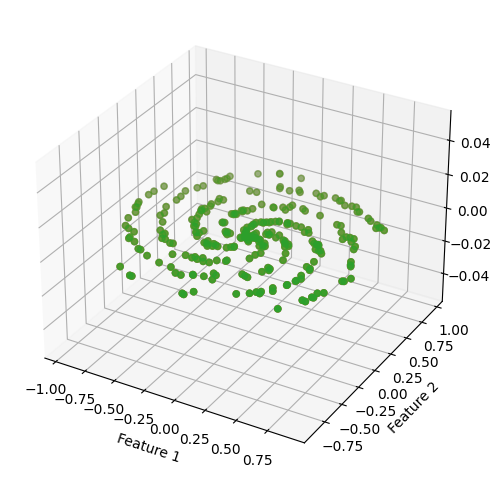

In [82]:
#Plot in 2D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
line, = ax.plot(x, label='Feature 1')
line, = ax.plot(y, label='Feature 2')
ax.legend(loc = 'upper left', fontsize ='x-large')
plt.show()

#Plot in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
for datapoint in testdf:
  ax.scatter(x, y)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

This plot clearly shows the circular patteren. The patteren between the two features indecates that they are correlated and that one of them maybe should be droped in a statistical analysis of the dataset.

But it is still unclear if the two features can be used (in a ML-model) to make predictions that match the labels.

b: design a neural network using pytorch to correctly assign labels
- Describe your network
- Describe your training strategy
- Describe your results and discuss the observed performance
- Visualize network performance similar to:


In [231]:
#First step is to find the number of classes as it is needed for the models outputlayer
classes = traindf[0].unique().tolist()
print("Labels: ", classes)

#Create Model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.inputLayer = nn.Linear(2, 32, bias=False)
        self.hiddenLayer1 = nn.Linear(32, 64)
        self.hiddenLayer2 = nn.Linear(64, 32)
        self.outputLayer = nn.Linear(32, len(classes))

    def forward(self, x):
        out = self.inputLayer(x)
        out = F.relu(out)
        out = self.hiddenLayer1(out)
        out = F.relu(out)
        out = self.hiddenLayer2(out)
        out = F.relu(out)
        out = self.outputLayer(out)
        #out = F.softmax(out, dim=1) #Removed because it made the preformace 2-3% worse?
        return out

Labels:  [2.0, 0.0, 4.0, 3.0, 1.0]


In [232]:
#Load data
#train:
X = torch.stack([torch.tensor(traindf.iloc[:,1]).float(), torch.tensor(traindf.iloc[:,2]).float()])
X = torch.transpose(X,0,1)
Y = torch.tensor(traindf.iloc[:,0])
trainDataset = torch.utils.data.TensorDataset(X, Y)

#test:
X = torch.stack([torch.tensor(testdf.iloc[:,1]).float(), torch.tensor(testdf.iloc[:,2]).float()])
X = torch.transpose(X,0,1)
Y = torch.tensor(testdf.iloc[:,0])
testDataset = torch.utils.data.TensorDataset(X, Y)

In [233]:
#Train Model
nEpoch = 40
learningRate = 0.001
batchSize = 32

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
c = torch.nn.CrossEntropyLoss()

trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True)

iter = 0
for iEpoch in range(nEpoch):
    for xbatch,ybatch in trainDataLoader:
        optimizer.zero_grad() #reset gradients
        output = model(xbatch)
        loss = c(output, ybatch.to(torch.long))
        loss.backward() #calculate gradients
        optimizer.step() #update weights

        iter+=1
        if iter%50==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for features, ylabels in trainDataLoader:
                outputs = model(features)
                _, predicted = torch.max(outputs.data, 1)
                total += ylabels.size(0)
                correct += (predicted == ylabels).sum()

            accuracy = 100 * correct/total
            print('________________ Train Epoch:', iEpoch,'________________')
            print("Iteration: {}. Loss: {}. Accuracy: {}  \n".format(iter, round(loss.item(),5), round(accuracy.item(),2)))

print('')
print('Final train accuracy:', round(accuracy.item(),2))

________________ Train Epoch: 1 ________________
Iteration: 50. Loss: 1.57948. Accuracy: 26.83  

________________ Train Epoch: 2 ________________
Iteration: 100. Loss: 1.5301. Accuracy: 26.92  

________________ Train Epoch: 3 ________________
Iteration: 150. Loss: 1.33082. Accuracy: 29.17  

________________ Train Epoch: 5 ________________
Iteration: 200. Loss: 1.46205. Accuracy: 31.0  

________________ Train Epoch: 6 ________________
Iteration: 250. Loss: 1.21077. Accuracy: 33.92  

________________ Train Epoch: 7 ________________
Iteration: 300. Loss: 1.12259. Accuracy: 45.83  

________________ Train Epoch: 9 ________________
Iteration: 350. Loss: 0.84836. Accuracy: 59.58  

________________ Train Epoch: 10 ________________
Iteration: 400. Loss: 0.91479. Accuracy: 75.25  

________________ Train Epoch: 11 ________________
Iteration: 450. Loss: 0.67027. Accuracy: 81.58  

________________ Train Epoch: 13 ________________
Iteration: 500. Loss: 0.63257. Accuracy: 82.33  

__________

In [234]:
#test model:
testDataLoader = torch.utils.data.DataLoader(testDataset, batch_size=batchSize, shuffle=True)

correct = 0
total = 0
estimatedLabels = np.empty(0,)
trueLabels = np.empty((0,))

for features, ylabels in testDataLoader:
    outputs = model(features)
    _, predicted = torch.max(outputs.data, 1)
    total += ylabels.size(0)
    correct += (predicted == ylabels).sum()

testAccuracy = 100 * correct/total
print("Test Accuracy: ", round(testAccuracy.item(),2))

Test Accuracy:  95.65


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
